<a href="https://colab.research.google.com/github/jameswpm/micrograd_copy/blob/main/micrograd_copy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Copy of micrograd library

From [NN zero-to-hero](https://karpathy.ai/zero-to-hero.html)

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def f(x):
    return 3 * x ** 2 - 4 * x +5


In [3]:
f(3.0)

20.0

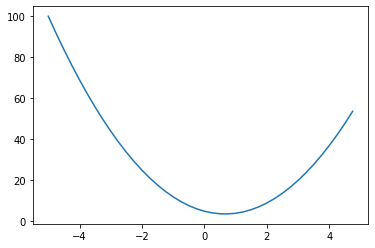

In [4]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [5]:
h = 0.0001
x = 3.0
(f(x + h) - f(x))/h

14.000300000063248

In [6]:
# more complex
a = 2.0
b = -3.0
c = 10.0
d = a*b +c
print(d)

4.0


In [7]:
# derivative of d regarding a
h = 0.001

#inputs
a = 2.0
b = -3.0
c = 10.0


d1 = a*b +c
a += h
d2 = a*b +c

print('d1', d1)
print("d2", d2)
print('slope', (d2 - d1)/h)


d1 4.0
d2 3.997
slope -3.0000000000001137


In [8]:
# derivative of d regarding b

h = 0.001

#inputs
a = 2.0
b = -3.0
c = 10.0


d1 = a*b +c
b += h
d2 = a*b +c

print('d1', d1)
print("d2", d2)
print('slope', (d2 - d1)/h)

d1 4.0
d2 4.002
slope 1.9999999999997797


In [85]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
    
    def __repr__(self) -> str:
        return f"Value(data={self.data})"

    def __rmul__(self,other):
        return self * other

    def __add__(self, other : 'Value') -> 'Value':
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward

        return out

    def __sub__(self, other): # self  - other
        return self + (-other)
    
    def __neg__(self, other): # -self
        return self * -1

    def __mul__(self, other : 'Value') -> 'Value':
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out

    def __truediv__(self, other): # self /other
        return self * (other**-1)
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        
        out._backward = _backward

        return out
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self, ), f'**{other}')

        def _backward():
            self.grad += (other * (self.data ** (other - 1))) * out.grad # must to check
        
        out._backward = _backward

        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out = Value(t, (self,), 'tanh')
        out._backward = _backward

        return out

    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [10]:
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad,), shape='record')
        if n._op:
            # if this value is a result of some operation, create an op for it
            dot.node(name = uid + n._op, label = n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

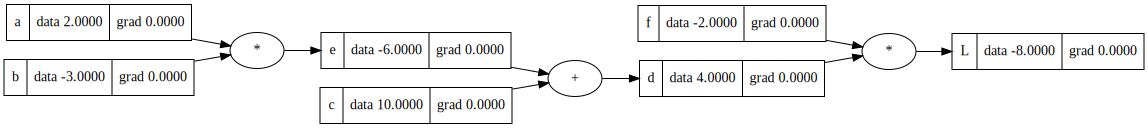

In [11]:
draw_dot(L)

Talking on Neural net terms, being L a imagine loss function, we are insterested in how the updates on each variable a,b,c, et...affect the loss function L,
so a, b, and c can be interpreted as the weights of the neural net function. How L is sensitive to any param (a. b. c?)

To perform this analysis of the loss function L, we can calculate the derivative of L regard each parameter/weight. At th Value class, this is done using the grad attr

In this example, they are, of course, just random numbers

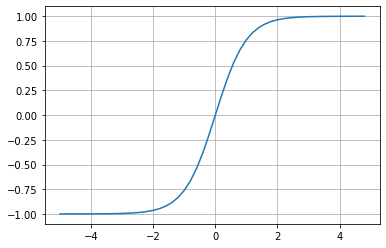

In [15]:
# function for a neuron
plt.plot(np.arange(-5, 5, 0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid();

In [86]:
#inputs xa, x2
x1 = Value (2.0, label='x1')
x2 = Value(0.0, label='x2')
#weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# vbias of the neuron
b = Value(6.8813735870195432, label='b')

x1w1 = x1 * w1 ; x1w1.label = "x1*w1"
x2w2 = x2 * w2 ; x2w2.label = "x2*w2"
x1w1x2w2 = x1w1 + x2w2 ; x1w1x2w2.label = "x1*w1 + x2*w2"
n = x1w1x2w2 + b ; n.label = 'n'

#activation function
#o = n.tanh(); o.label = 'o'

#activation function decoupled
#--#
e = (2*n).exp()
minus = e - 1
plus = e + 1
o = (e - 1) / (e + 1)
#--#
o.backward()

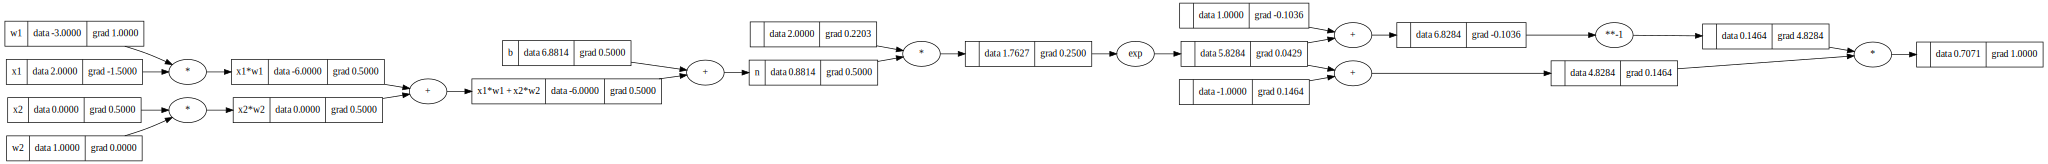

In [87]:
draw_dot(o)

In [ ]:
# same thing using PyTorch